# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-Trees-YOUR-SURNAME.ipynb') with your answers and code to the Moodle/Ecampus before the deadline.


We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1xxxx* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [183]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [184]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [185]:
# Choose Atlas (here AAL2)
X=T1AAL2 # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAAL2 # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAAL2.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

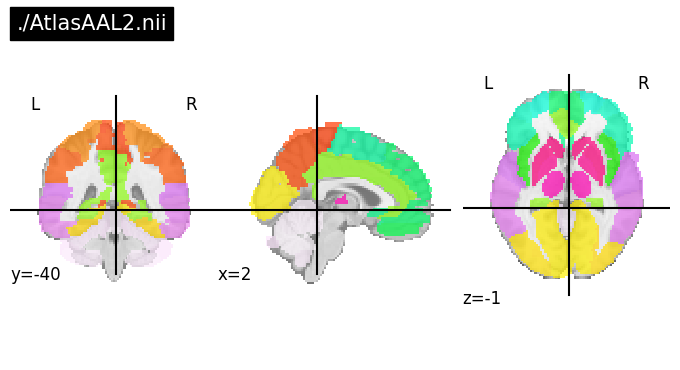

In [186]:
plotting.plot_roi(atlas, title=atlas)
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to create a training and test set.

In [187]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

And then we need to check whether out features need to be standardized or normalized. Let's have a look at them. Remember that if features can have both negative and positive values, as a rule of thumb, they should be standardized. If they only have positive values, a normalization is usually used. 

As already said, please remember that you should learn the standardization/normalization (namely learn the average/std or the max/min values) ONLY in the training set and then use the same values also in the test set. You should NOT use the entire dataset (both training and test) for standardization/normalization. Otherwise, you would have a *data leakage*, namely you would use data (the test set) that you should not use during training. 

Using normalization.


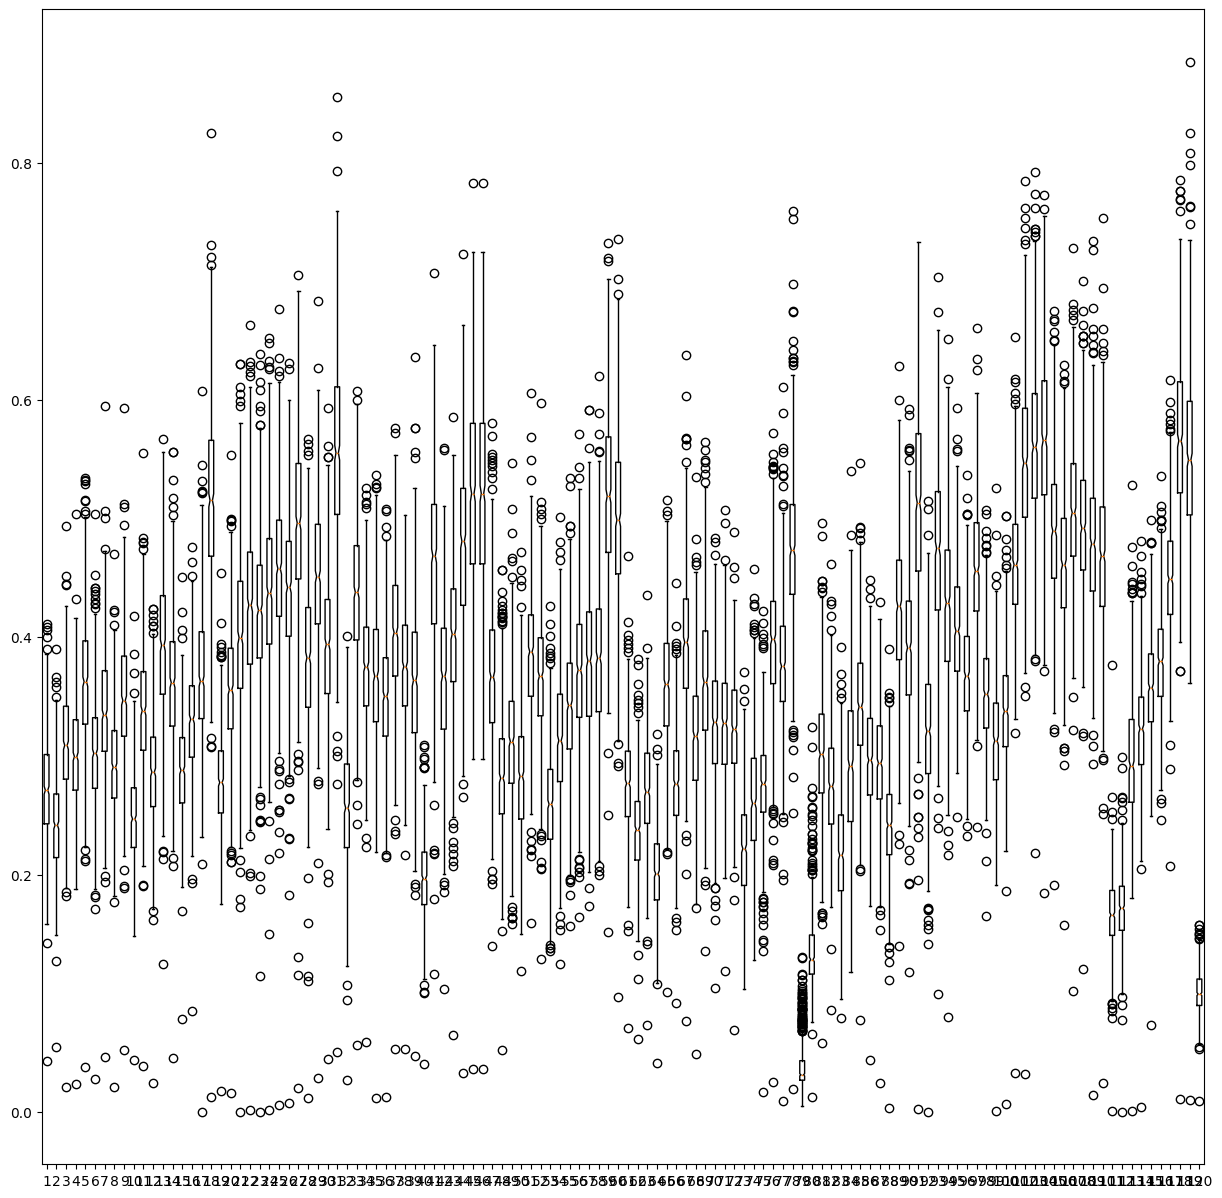

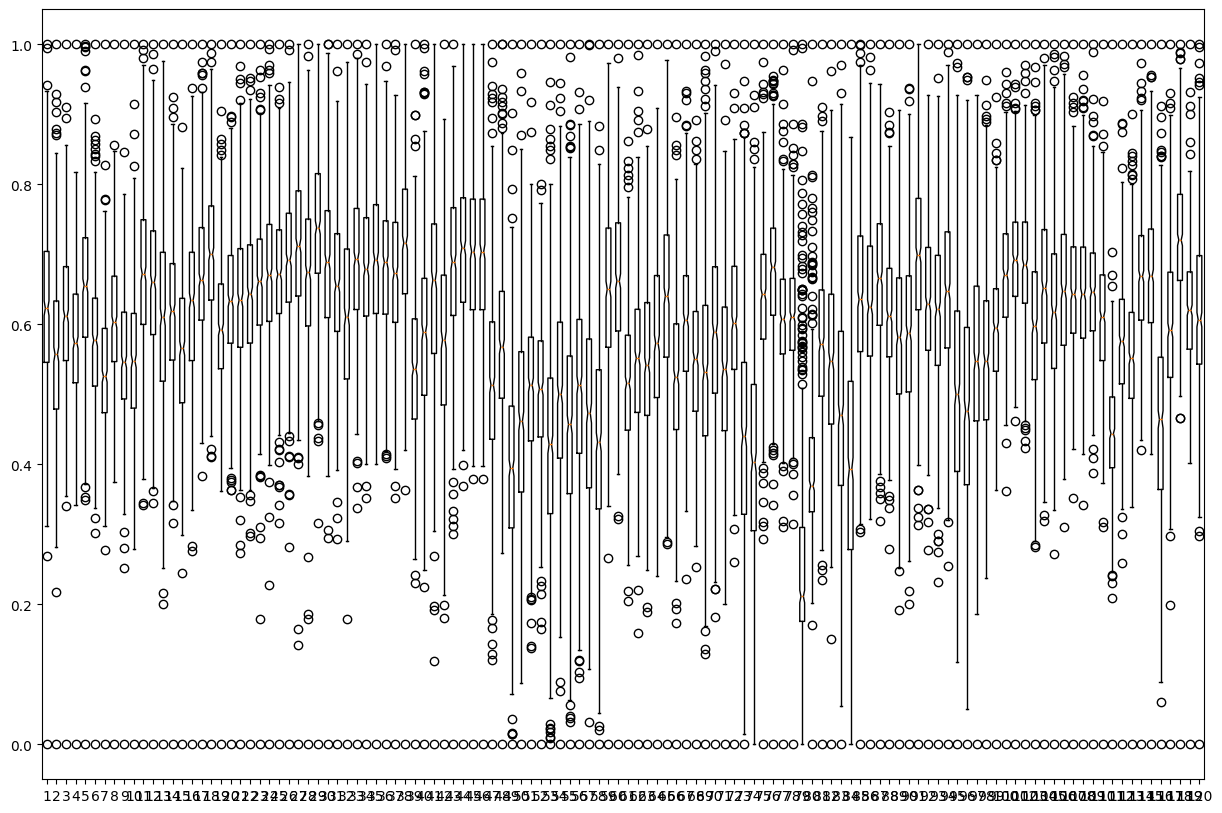

In [188]:
plt.figure(figsize=(15,15))
plt.boxplot(X,notch=True);

# Standardization/Normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Inspect the minimum and maximum to decide on normalization or standardization
min_values = X_train.min(axis=0)
max_values = X_train.max(axis=0)

if (min_values >= 0).all() and (max_values > 0).all():
    # Use normalization
    scaler = MinMaxScaler()
    print("Using normalization.")
else:
    # Use standardization
    scaler = StandardScaler()
    print("Using standardization.")

# Fit on training set
scaler.fit(X_train)

# Transform both training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

plt.figure(figsize=(15,10))
plt.boxplot(X_train,notch=True);

Then, we can fit a Decision tree, with the default setting, using the following code:

In [189]:
# Fitting Decision Trees 
Tree = DecisionTreeClassifier(random_state=0)
Tree.fit(X_train,y_train)
# Score in the training set
print('Score in the training set is {0}'.format(Tree.score(X_train,y_train)) )
# Score in the test set
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 1.0
Score in the test set is 0.7553191489361702


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 2 and 15) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'.

**Question:** What is the best value ? What happens if you split differently your data (change `random_state`in the function `train_test_split`) ? 


**Answer:**

From the analysis, it's evident that the optimal choice is the one that reduces test error, effectively balancing model fit and generalization capabilities. Specifically, a min_samples_split of 15 and a min_samples_leaf of 14 emerge as ideal, supporting the notion that higher minimum thresholds enhance model generalization—this is because allowing only one or two samples per leaf can cause overfitting.

While the enhancement seen with min_samples_leaf is notably more significant, the overall impact on results from both parameters does not vary dramatically. Furthermore, when experimenting with different splits (altering the random state), although the optimal values shift, the variance in error rates remains relatively consistent across the board.

The value of min_samples_split that maximizes the training score is :  6
The value of min_samples_split that maximizes the test score is :  6


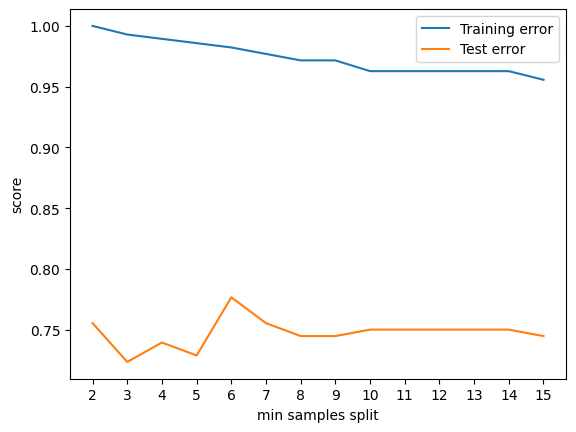

In [190]:
# min_samples_split

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_split=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)

best_min_samples_split=TTest.index(max(TTest))+2

plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_split that maximizes the training score is : ",best_min_samples_split)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_split that maximizes the test score is : ",best_min_samples_split)
plt.legend();


The value of min_samples_leaf that maximizes the training score is :  14
The value of min_samples_leaf that maximizes the test score is :  14


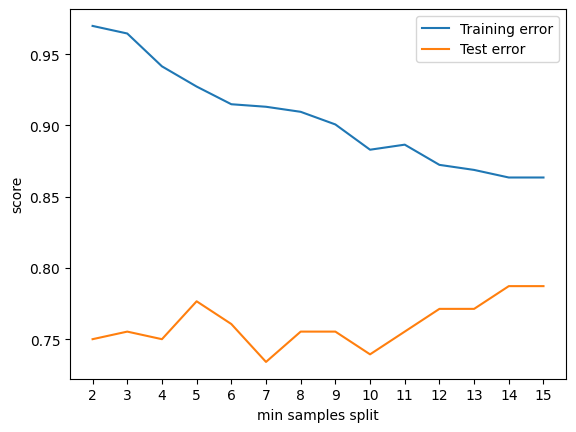

In [191]:
# min_samples_leaf

TTest=[]
TTrain=[]
for i in range(2,16):
    Tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=0)
    Tree.fit(X_train, y_train)
    scoreTrain=Tree.score(X_train, y_train)
    scoreTest=Tree.score(X_test, y_test)
    TTrain.append(scoreTrain)
    TTest.append(scoreTest)

best_min_sample_leaf=TTest.index(max(TTest))+2

plt.plot(TTrain,label='Training error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
print("The value of min_samples_leaf that maximizes the training score is : ",best_min_sample_leaf)
plt.plot(TTest,label='Test error');
plt.xticks(np.arange(14), ('2', '3', '4', '5', '6','7','8','9','10','11','12','13','14','15'))
plt.xlabel('min samples split')
plt.ylabel('score')
print("The value of min_samples_leaf that maximizes the test score is : ",best_min_sample_leaf)
plt.legend();

Try to add Gaussian noise to the data (using for instance zero mean and 0.05 for $\sigma$) and, using the best hyperparameters found before in the test set (you can use both `min_samples_leaf` and `min_samples_split`), look at the test score. Repeat this process several times and compare the results with the score obtained without adding noise. 

**Question**: Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)* if you have standardized the features and *noise = np.abs(np.random.normal(mu, sigma))* if you have normalized them (we use *np.asb()* to take only positive values and $\sigma$ should be small in order to (almost) preserve the range of the features between 0 and 1)

**Answer:**

The graph illustrates that the results are not consistent. Typically, introducing noise leads to poorer outcomes, which aligns with expectations.

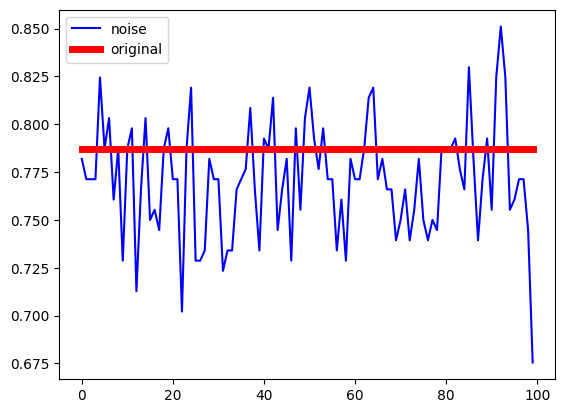

In [192]:
Tree = DecisionTreeClassifier(min_samples_split=best_min_samples_split,min_samples_leaf=best_min_sample_leaf,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

mu = 0
sigma = 0.05

for k in range(100):    
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] += np.abs(np.random.normal(mu,sigma,X_train.shape[1]))
    
    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)
    
plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')       
plt.legend();

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

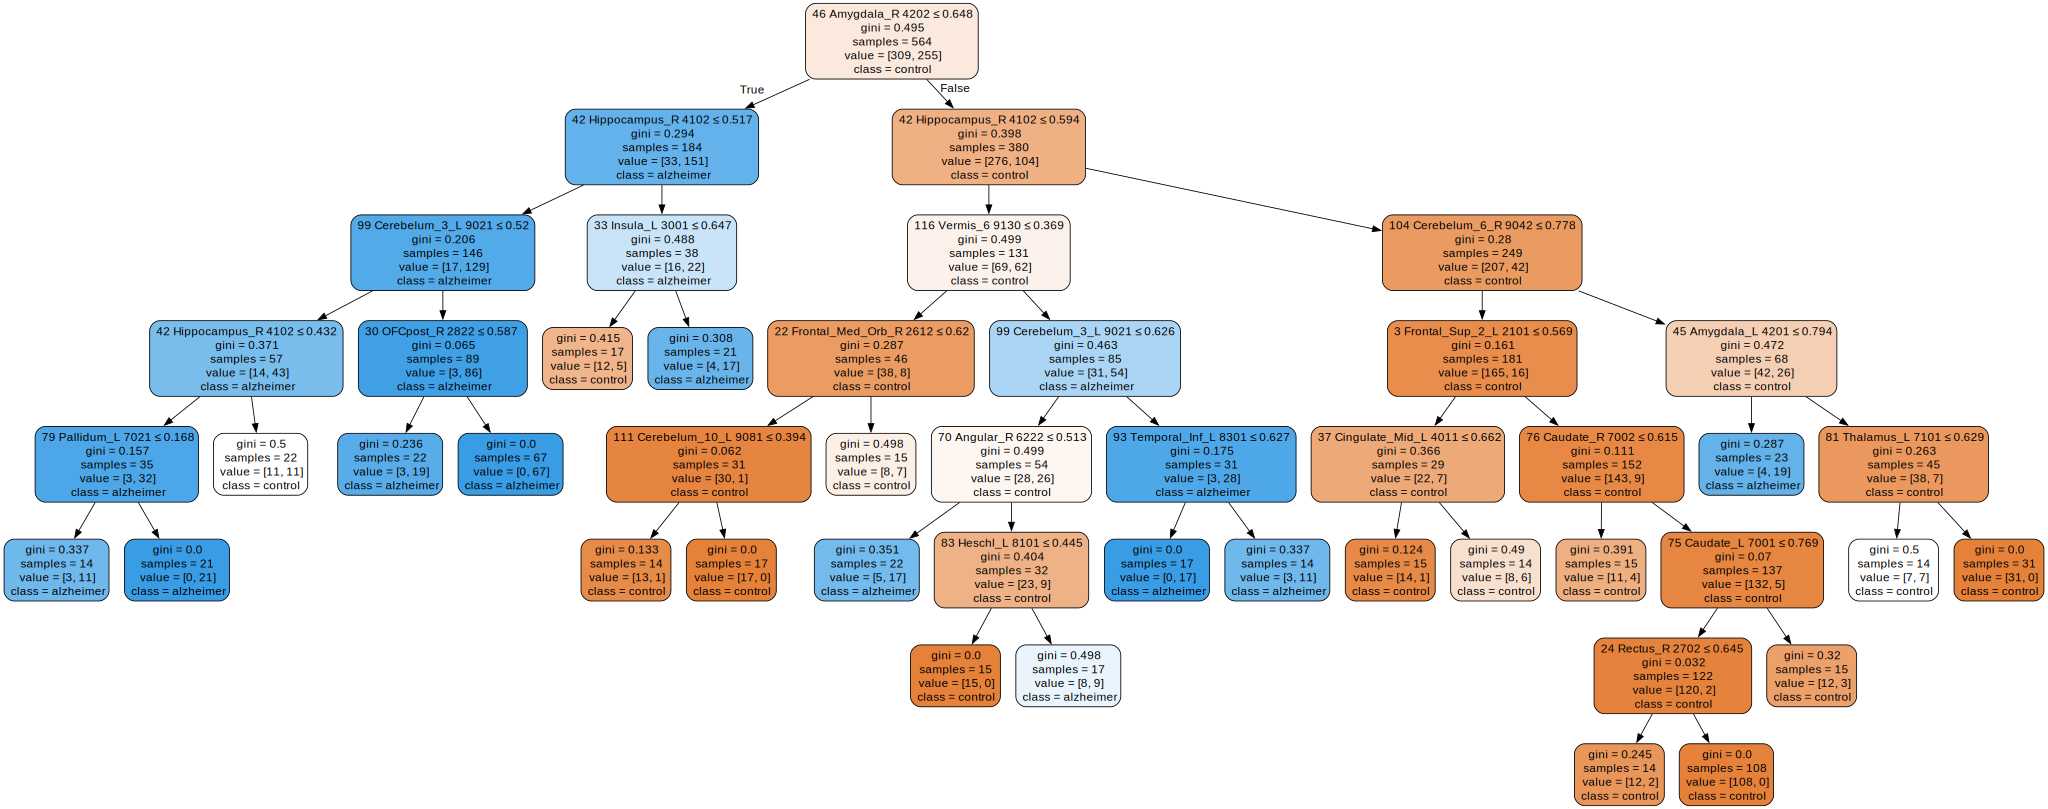

In [193]:
import graphviz 

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data.

**Question**: Is it the same ? You can try several times, for different levels of noise. Comment the results

**Answer**:

The introduction of noise to the dataset impacts the structure of the resulting decision tree. For minor noise additions, the initial segments of the tree near the root remain relatively unaffected, with only the deeper levels experiencing variations. However, as the noise intensity escalates, the alterations throughout the tree become increasingly significant.

This phenomenon stems from the absence of a global optimization approach (which is NP-complete) in favor of a greedy algorithm that makes locally optimal choices. Consequently, while the model is highly interpretable, it lacks stability, meaning that even slight modifications in the input data can lead to a markedly different (and noisy) decision tree. This instability is inherently linked to the hierarchical decision-making process of the model.

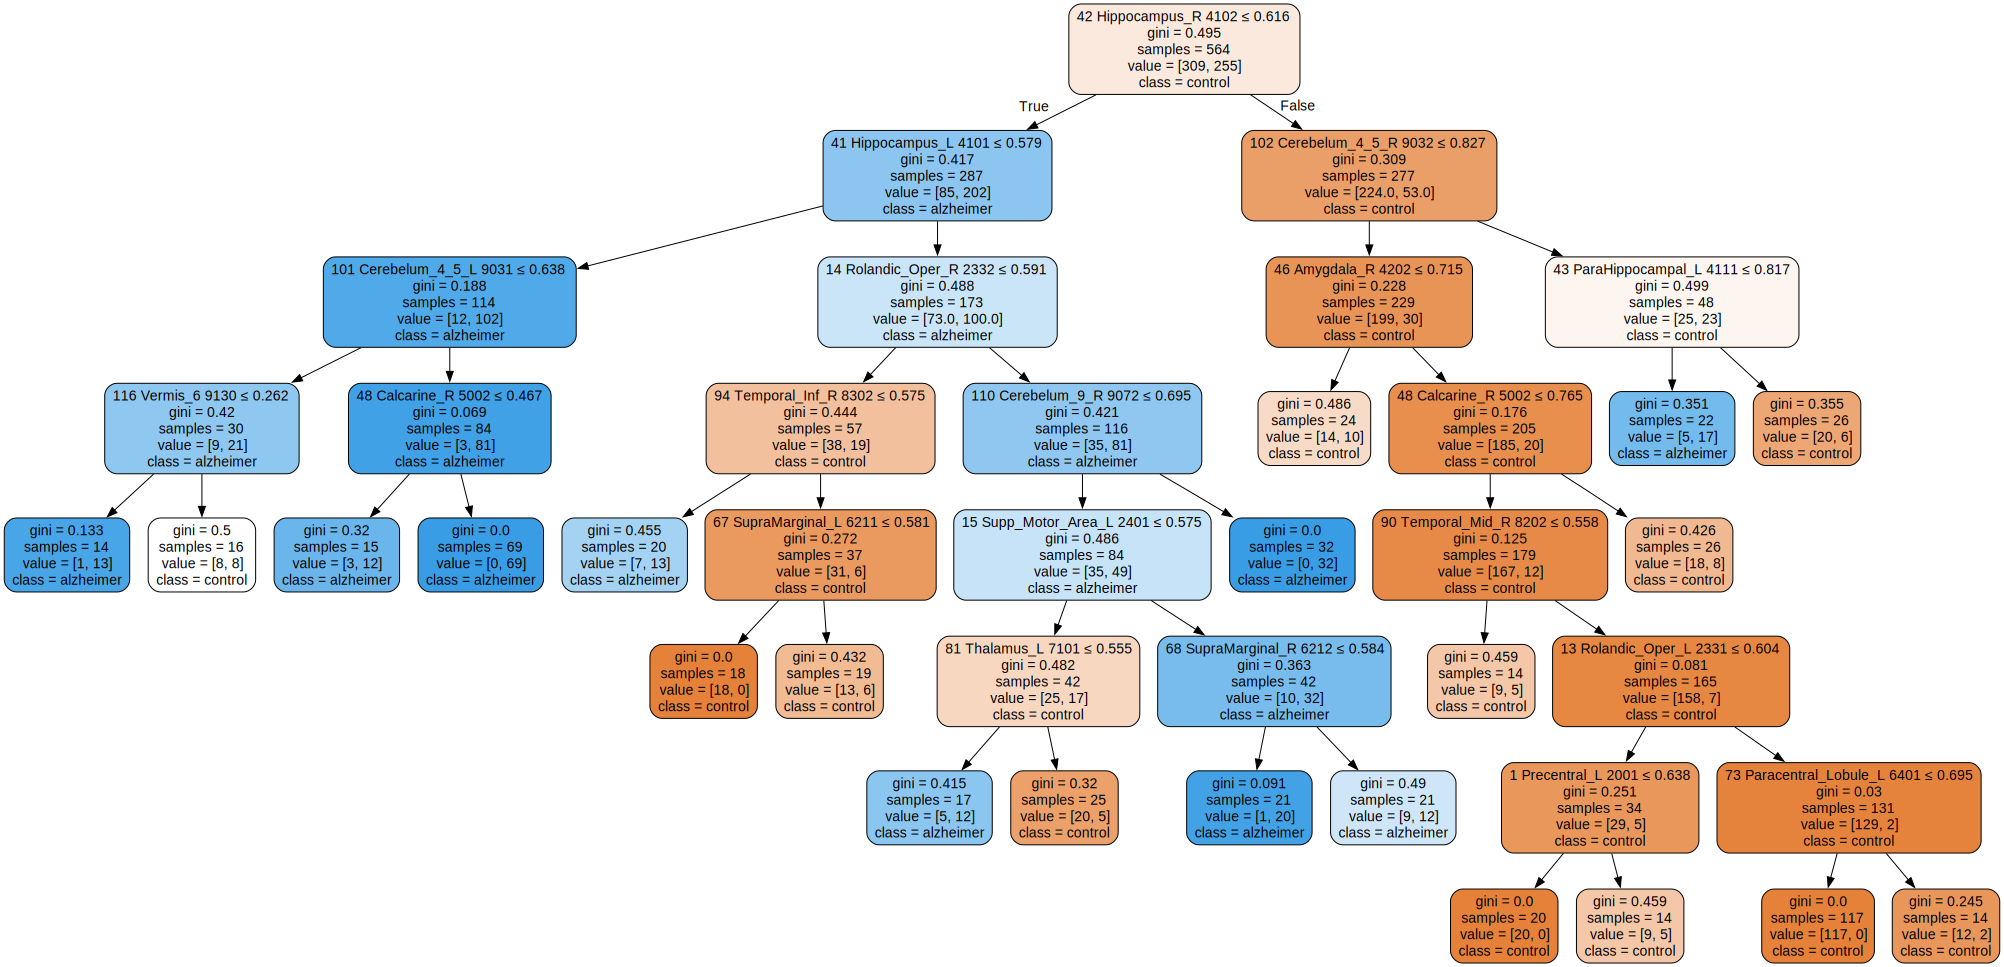

In [194]:
Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. 

**Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Question**: So far, we have used the standard score (ie accuracy). Would you use a different one ? If yes, which one and why ?

**Answer:**

The hyperparameters identified through cross-validation differ because the model exhibits considerable variation. This variance means that the outcome of cross-validation is influenced by the random division of data in the process, leading to different results.

Furthermore, experimenting with various evaluation metrics like F1 score, precision, and recall has not yielded improvements in the model's performance.

In [195]:
Tree =  DecisionTreeClassifier(min_samples_split=6,min_samples_leaf=14,random_state=0)
p_grid_tree = {'min_samples_leaf': np.arange(1, 10),'min_samples_split': np.arange(2, 10)}
grid_tree = GridSearchCV(Tree, p_grid_tree, cv=5)
grid_tree.fit(X_train, y_train)
print("Best Validation Score: {}".format(grid_tree.best_score_))
print("Best params: {}".format(grid_tree.best_params_))
print("Tree test score :",grid_tree.score(X_test,y_test))

best_params=grid_tree.best_params_

Best Validation Score: 0.7482142857142857
Best params: {'min_samples_leaf': 7, 'min_samples_split': 2}
Tree test score : 0.7340425531914894


Using the estimated optimal hyperparameers, plot the new decision tree using the *graphviz* library. 

**Question**: Is it the same as before? Do you see ROIs that are always close to the root of the tree among the different experiments ? If yes, what does it mean in your opinion ? Comment the results.

**Answer:**

Similar to the effect of introducing noise, the nodes near the root of the tree tend to remain consistent, with variations becoming more pronounced further down the tree. Indeed, the same regions of interest (ROIs) frequently appear at the top, underscoring their significance in predicting Alzheimer's disease. This consistency at the top levels suggests that these features are truly crucial in the model's predictive process.

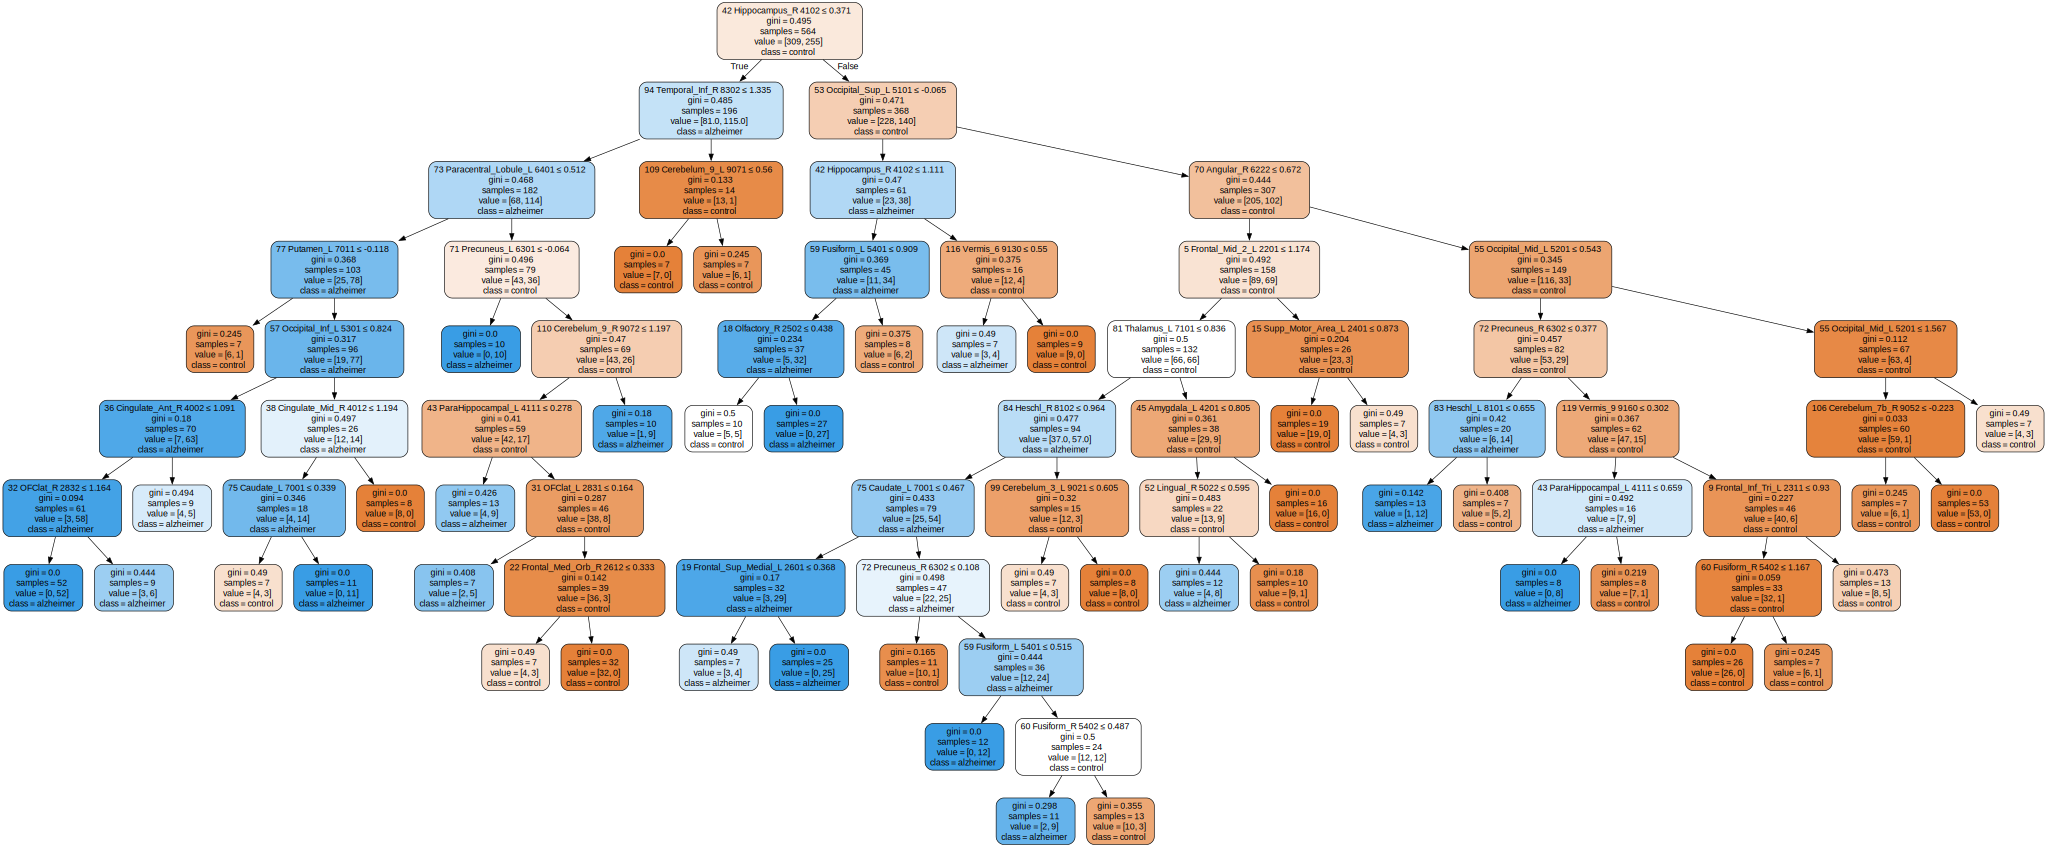

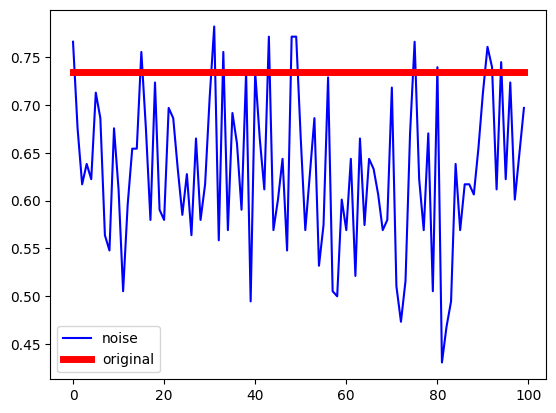

In [196]:
Tree = DecisionTreeClassifier(min_samples_split=2,min_samples_leaf=7,random_state=0)
scoreTestnoise=np.zeros(100)
scoreTest=np.zeros(100)

Tree.fit(X_train,y_train)
scoreTest[:] = Tree.score(X_test,y_test)

for k in range(100):
    X_train_temp=np.copy(X_train)
    for i in range(X_train.shape[0]):
        X_train_temp[i] = X_train[i] + np.random.normal(0,0.5,X_test.shape[1])

    Tree.fit(X_train_temp,y_train)
    scoreTestnoise[k] = Tree.score(X_test,y_test)

plt.plot(scoreTestnoise,'b',label='noise')
plt.plot(scoreTest,'r',linewidth=5.0,label='original')
plt.legend();

Tree.fit(X_train_temp,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. 

**Question**: What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

**Answer:**

The comparison between the original and noise-added data yields similar results, identifying the same optimal parameter for both scenarios. This consistency suggests that bagging may offer a more robust modeling approach than a standalone decision tree.

Regarding performance metrics, there is a slight improvement in scores with bagging compared to those of the decision tree. This improvement becomes more pronounced when evaluating the model's performance with noise-added data, indicating bagging's enhanced resilience to data perturbations.

In [197]:
Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(bag,  p_grid_bagging , cv=5)
grid_bagging.fit(X_train, y_train.reshape(-1,))
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.810224399494311
Best params: {'n_estimators': 20}
Bagging test score : 0.851063829787234


In [198]:
# Bagging on noisy data

Tree = DecisionTreeClassifier(min_samples_leaf=best_params["min_samples_leaf"],min_samples_split=best_params["min_samples_split"], random_state=0)
p_grid_bagging = {'n_estimators': [5,10,15,20]}
bag=BaggingClassifier(estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(bag,  p_grid_bagging , cv=5)
grid_bagging.fit(X_train_temp, y_train.reshape(-1,))
print("Best Validation Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging test score :",grid_bagging.score(X_test,y_test))

Best Validation Score: 0.6046302149178256
Best params: {'n_estimators': 15}
Bagging test score : 0.7819148936170213


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [199]:
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}
grid_RF = GridSearchCV(RF, p_grid_RF, cv=5)
grid_RF.fit(X_train, y_train.reshape(-1,))
print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("RF test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.8155183312262958
Best params: {'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 30}
RF test score : 0.8829787234042553


**Answer:**

When applied to the test set, the results exhibit minimal variation with the introduction of noisy data, indicating a level of robustness surpassing that of bagging. However, in terms of result quality, the performance is closely aligned with that of bagging, showing only a marginal improvement over the best scenario achieved by the decision tree. This suggests that while the model demonstrates enhanced stability against data noise, its effectiveness in improving prediction outcomes compared to simpler models is limited.

Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

In [200]:
# Random Forest on noisy data
RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}
grid_RF = GridSearchCV(RF, p_grid_RF, cv=5)
grid_RF.fit(X_train_temp, y_train.reshape(-1,))
print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))
print("RF test score :",grid_RF.score(X_test,y_test))

Best Validation Score: 0.608138432364096
Best params: {'max_features': 'log2', 'min_samples_leaf': 6, 'n_estimators': 30}
RF test score : 0.6329787234042553


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 44 representing 45 Amygdala_L 4201
 (0.071559)
2. feature 45 representing 46 Amygdala_R 4202
 (0.061895)
3. feature 43 representing 44 ParaHippocampal_R 4112
 (0.058864)
4. feature 40 representing 41 Hippocampus_L 4101
 (0.054933)
5. feature 41 representing 42 Hippocampus_R 4102
 (0.038490)
6. feature 92 representing 93 Temporal_Inf_L 8301
 (0.038084)
7. feature 42 representing 43 ParaHippocampal_L 4111
 (0.032408)
8. feature 93 representing 94 Temporal_Inf_R 8302
 (0.023882)
9. feature 86 representing 87 Temporal_Pole_Sup_L 8121
 (0.021993)
10. feature 80 representing 81 Thalamus_L 7101
 (0.021200)


c:\Users\adnan\Desktop\Documents\Telecom Paris\Etudes\IMA\IMA205\TPs\TP05\ENV_IMA205_TP05\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


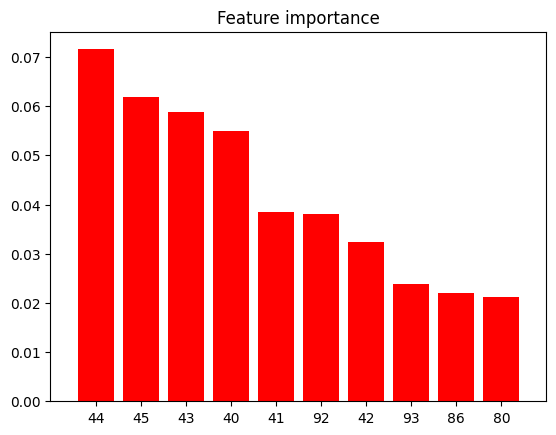

In [201]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question**: Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 

**Answer:**

The analysis of structural MRI markers is fundamental in diagnosing and understanding Alzheimer's disease (AD), particularly emphasizing the medial temporal structures, including the hippocampus, as crucial diagnostic markers at the mild cognitive impairment (MCI) stage. The documents reviewed underscore the significance of these regions in AD's pathology and diagnosis, aligning with the feature ranking provided, which highlights the Amygdala_L, Amygdala_R, Hippocampus_L, and Hippocampus_R among the top important features. This concordance between the literature and the feature ranking suggests a valid emphasis on these areas for AD research and diagnostics. While the documents do not offer a direct comparison to the feature ranking, they reinforce the importance of these regions in the neurodegenerative processes of AD, supporting the feature ranking's relevance and accuracy within the current scientific understanding and clinical practices.

We can also inspect the data using only pairs of the most important features

c:\Users\adnan\Desktop\Documents\Telecom Paris\Etudes\IMA\IMA205\TPs\TP05\ENV_IMA205_TP05\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adnan\AppData\Local\Temp\ipykernel_21940\3244815994.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
c:\Users\adnan\Desktop\Documents\Telecom Paris\Etudes\IMA\IMA205\TPs\TP05\ENV_IMA205_TP05\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adnan\AppData\Local\Temp\ipykernel_21940\3244815994.py:30: UserWarning: No data for colormap

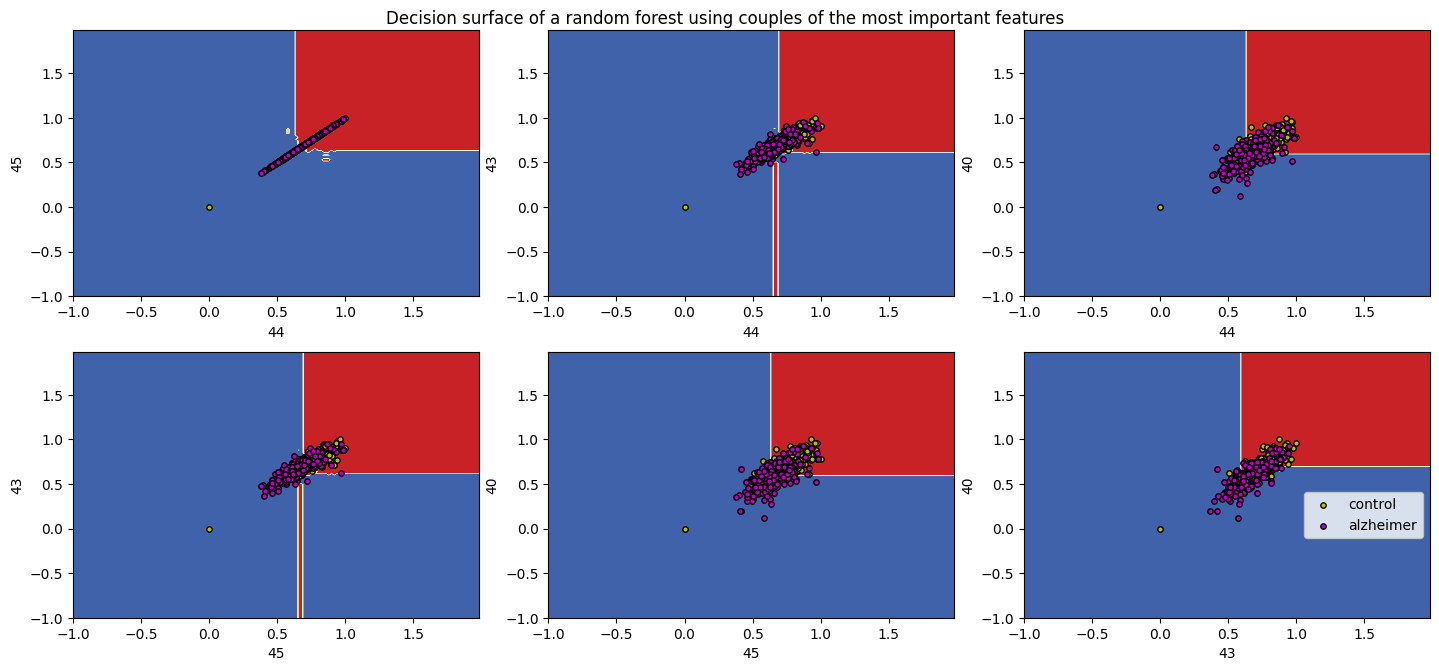

In [202]:
plt.figure(figsize=(15,7))
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "ym"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question**: Which is the best couple of features ?

**Answer:**

Based on the plots, it appears that the middle plot in the bottom row (features 40 and 45) shows a relatively clear separation between the Alzheimer's group and the control group, with minimal overlap compared to other plots. However, without numerical metrics such as accuracy, precision, recall, or area under the ROC curve, this observation is purely qualitative.

For a definitive answer, these feature pairs should be evaluated using the mentioned statistical metrics on a validation dataset to see which pair indeed performs the best.

**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs. What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.

**Answer:**

The outcomes derived from the AAL2 align with those from HAMMERS, corroborating the literature's findings that place the amygdala and hippocampus among the top five regions of interest (ROIs) for both atlases. However, when examining the AICHA atlas, there is a divergence; the correspondence with both prior atlases and the established research is not as strong, with the thalamus being the primary ROI that remains consistent with previous findings.

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 192


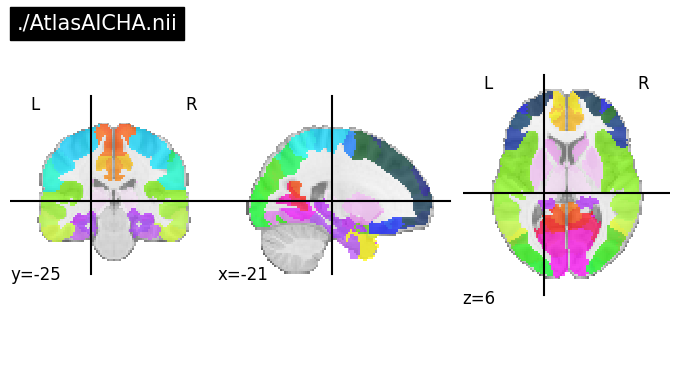

Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.043653)
2. feature 187 representing 188	N_Thalamus-5	189
 (0.023622)
3. feature 183 representing 184	N_Thalamus-1	185
 (0.020061)
4. feature 172 representing 173	N_Amygdala-1	174
 (0.019357)
5. feature 170 representing 171	G_Fusiform-6	172
 (0.019175)
6. feature 94 representing 95	G_Temporal_Inf-2	96
 (0.018156)
7. feature 188 representing 189	N_Thalamus-6	190
 (0.016798)
8. feature 112 representing 113	G_Supp_Motor_Area-3	114
 (0.016730)
9. feature 141 representing 142	S_Parietooccipital-1	143
 (0.016458)
10. feature 115 representing 116	S_Cingulate-3	117
 (0.016275)


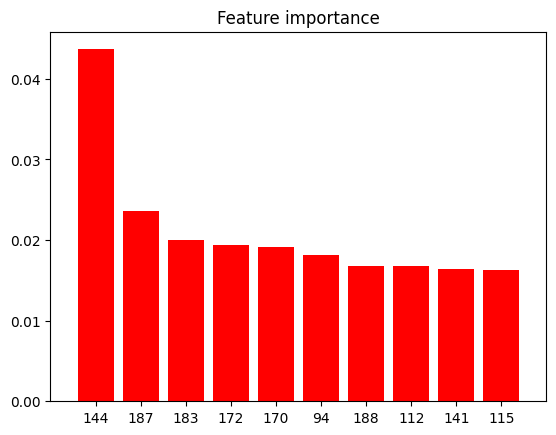

In [203]:
# Choose Atlas (here AICHA)
X=T1AICHA # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsAICHA # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasAICHA.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)
# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train,y_train)

best_params_f= grid_RF.best_params_

RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
  print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI (features) is: 68


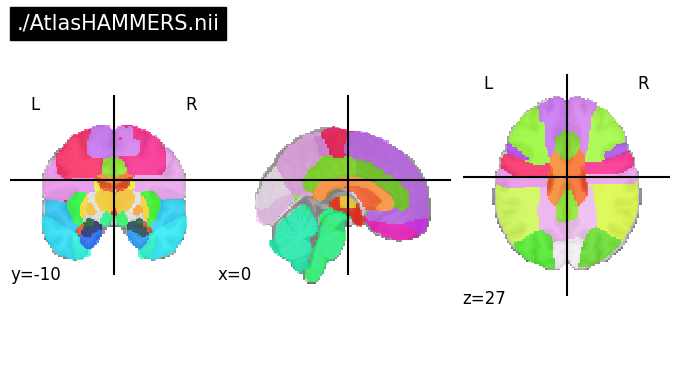

Feature ranking:
1. feature 3 representing Right Amygdala                         (0.137882)
2. feature 2 representing Left Amygdala                          (0.076077)
3. feature 46 representing Left Lateral Temporal Ventricle        (0.064486)
4. feature 47 representing Right Lateral Temporal Ventricle       (0.053561)
5. feature 0 representing Left Hippocampus                       (0.041756)
6. feature 12 representing Left Inferior Middle Temporal Gyri     (0.036136)
7. feature 1 representing Right Hippocampus                      (0.033685)
8. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.033072)
9. feature 41 representing Right Thalamus                         (0.021862)
10. feature 4 representing Left Anterior Medial Temporal Lobe     (0.021468)


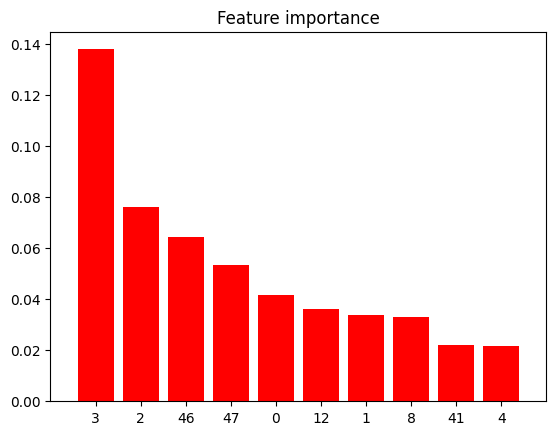

In [204]:
# Choose Atlas (here HAMMERS)
X=T1HAMMERS # T1AAL2, T1AICHA, T1HAMMERS
labels=ROIlabelsHAMMERS # ROIlabelsAAL2, ROIlabelsAICHA, ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii' #AtlasAAL2.nii, AtlasAICHA.nii, AtlasHAMMERS.nii

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI (features) is: {0}'.format(M))

plotting.plot_roi(atlas, title=atlas)
plotting.show()

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size=0.3, random_state=42)
# Normalize data (each feature will be scaled into the range 0,1)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

RF=RandomForestClassifier(random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train,y_train)

best_params_f= grid_RF.best_params_

RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
  print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()